# Informative Stimulus Dimensions

In [1]:

import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import normalize

import dreye

When running experiments, it can be useful to define main dimensions along which to vary light sources. This simplifies the number of stimuli presented and can make it easy to combine dimensions together in a linear way in LED space and have it translate to photoreceptor space. Here, we show an example to define informative stimulus (light source) dimensions according to the color (photoreceptor) space of the animal. Especially when dealing with polychromatic animals this is useful to limit the number of dimensions to span while also retaining most color information.

In [2]:
filters_colors = ['magenta', 'blue', 'green', 'red']
sources_colors = ['violet', 'cyan', 'orange', 'purple', 'black', 'pink']

# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([350, 370, 450, 550])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None], A_beta=0)

led_peaks = np.array([345, 365, 417, 455, 560, 617])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters,
    ### ADDING FILTER UNCERTAINTY
    ### In this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls,
    # labels for each photoreceptor type (optional)
    labels=['U', 'S', 'M', 'L'],
    # LED array, optional
    sources=sources,
    # lower bound of each LED, optional
    lb=np.zeros(len(sources)),
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.arange(len(sources)) * 0.1,
    # labels for sources, optional
    sources_labels=['D', 'U', 'V', 'C', 'G', 'P'],
    baseline=0.0
)

# setting K according to intensities of our sources
source_bg = np.array([0.01, 0.01, 0.018, 0.025, 0.02, 0.02])
est.register_system_adaptation(source_bg)

In [4]:
nonneg_comps = est.find_nonneg_source_dimensions()
contrast_comps = est.find_nonneg_orth_source_dimensions()

/Users/gucky92/Documents/dreye/dreye/api/estimator.py:1119: UserWarning: `find_nonneg_source_dimensions` is an experimental method and might not work as expected. Use with caution. This method might be removed or changed in future versions.
  warnings.warn(
/Users/gucky92/miniconda3/envs/dreye/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/gucky92/Documents/dreye/dreye/api/estimator.py:1119: UserWarning: `find_nonneg_source_dimensions` is an experimental method and might not work as expected. Use with caution. This method might be removed or changed in future versions.
  warnings.warn(


In [5]:
contrast_comps

array([[ 1.        , -1.        ,  0.499975  , -0.49995833],
       [ 1.        , -1.        ,  0.499975  , -0.49995833],
       [ 1.        , -1.        , -1.        ,  0.99996667],
       [ 1.        ,  1.        , -1.        , -1.        ],
       [ 1.        ,  1.        ,  0.500025  ,  0.499975  ],
       [ 1.        ,  1.        ,  0.500025  ,  0.499975  ]])

In [6]:
nonneg_comps

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [7]:
filters_colors = ['magenta', 'blue', 'green', 'red']
sources_colors = ['violet', 'cyan', 'orange', 'purple']

# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([350, 370, 450, 550])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None], A_beta=0)

led_peaks = np.array([345, 417, 455, 560])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters,
    ### ADDING FILTER UNCERTAINTY
    ### In this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls,
    # labels for each photoreceptor type (optional)
    labels=['U', 'S', 'M', 'L'],
    # LED array, optional
    sources=sources,
    # lower bound of each LED, optional
    lb=np.zeros(len(sources)),
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.arange(len(sources)) * 0.1,
    # labels for sources, optional
    sources_labels=['D', 'U', 'V', 'C'],
    baseline=0.0
)

# setting K according to intensities of our sources
source_bg = np.array([0.01, 0.01, 0.018, 0.025])
est.register_system_adaptation(source_bg)

In [8]:
est.underdetermined

False

In [10]:
contrast_comps = est.find_nonneg_orth_source_dimensions()

/Users/gucky92/miniconda3/envs/dreye/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [11]:
contrast_comps

array([[ 1.        , -1.        ,  0.99999999, -0.99990001],
       [ 1.        , -1.        , -1.        ,  0.99995   ],
       [ 1.        ,  1.        , -1.        , -1.        ],
       [ 1.        ,  1.        ,  1.        ,  0.99995   ]])

Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1021.21it/s]


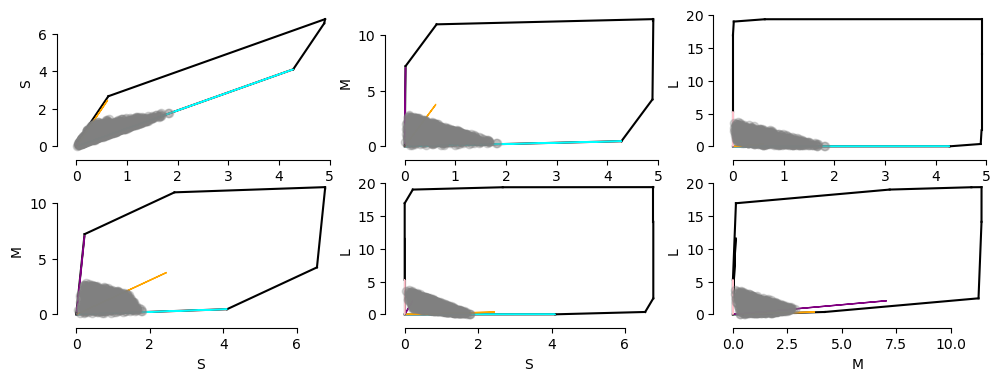

In [3]:
# Fitting with some points outside the hull
n_samples = 1000
l1 = 1.0 * len(filters)
B = est.sample_in_hull(n_samples, seed=2, l1=l1)

# Fitting points
Xhat, Bhat = est.fit(B, verbose=1)
Xhat, Bhat = est.fit_underdetermined(
    Bhat, underdetermined_opt=np.sum(source_bg), verbose=True,
    solver='ECOS', l2_eps=0.01
)
Xhat, Bhat, Bvar = est.minimize_variance(
    Bhat, 
    L1=Xhat.sum(-1), l2_eps=0.01, l1_eps=Xhat.sum(-1).mean() * 0.1, 
    solver='SCS', 
    norm=np.zeros(len(Xhat)), verbose=True
)

fig, axes = est.gamut_plot(
    B, colors=sources_colors, c='gray', alpha=0.3,
    ncols=3, fig_kws=dict(figsize=(12, 4))
)
sns.despine(offset=5, trim=True)
plt.show()

In [4]:
print("Mean capture across samples")
print(Bhat.mean(0))
print("Mean intensity across samples")
print(Xhat.mean(0))
print("Background intensity")
print(source_bg)

contrasts = (Xhat-source_bg)/source_bg
print("Mean contrast across samples")
print(contrasts.mean(0))

Mean capture across samples
[0.58176193 0.82815405 1.2939499  1.27794256]
Mean intensity across samples
[1.15083276e-08 1.16422026e-02 2.67611406e-02 3.09222487e-02
 2.82624933e-02 1.82230708e-02]
Background intensity
[0.01  0.01  0.018 0.025 0.02  0.02 ]
Mean contrast across samples
[-0.99999885  0.16422026  0.48673003  0.23688995  0.41312466 -0.08884646]


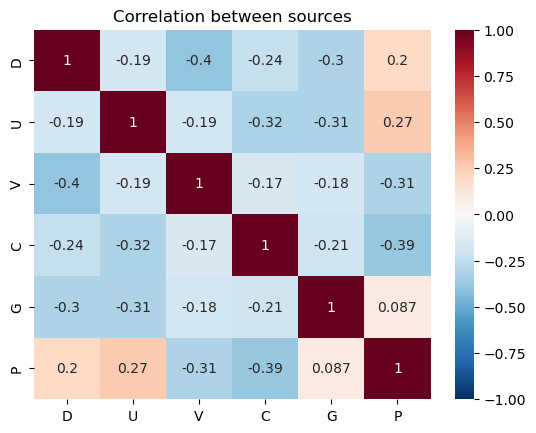

In [5]:
cov = contrasts.T @ contrasts
corr = cov / np.sqrt(np.outer(np.diag(cov), np.diag(cov)))
sns.heatmap(pd.DataFrame(corr, index=est.sources_labels, columns=est.sources_labels), annot=True, cmap='RdBu_r', vmin=-1, vmax=1, center=0)
plt.title("Correlation between sources")
plt.show()

In [6]:
# PCA on the contrasts
eigval, eigvec = np.linalg.eig(corr)
argsort = np.argsort(eigval)[::-1]
eigvec = eigvec[:, argsort]
eigval = eigval[argsort]
cum_expl_var = np.cumsum(eigval) / np.sum(eigval)

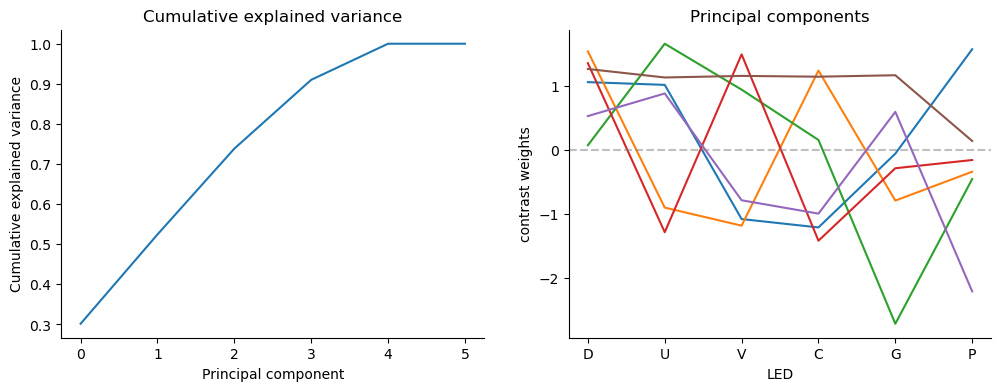

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title("Cumulative explained variance")
ax1.plot(cum_expl_var)
ax1.set_xticks(np.arange(len(sources)))
ax1.set_xlabel("Principal component")
ax1.set_ylabel("Cumulative explained variance")

# normalized eigenvectors
evec = eigvec / np.linalg.norm(eigvec, axis=0, keepdims=True, ord=1)
ax2.set_title("Principal components")
ax2.plot(evec*len(sources))
ax2.set_xticks(np.arange(len(sources)), est.sources_labels)
ax2.axhline(linestyle='--', color='gray', alpha=0.5)
ax2.set_xlabel("LED")
ax2.set_ylabel("contrast weights")

sns.despine()
plt.show()

In [8]:
# contrast dimensions/directions that span informative color dimensions
print("total achromatic contrast")
print(np.sum(evec, axis=0))
print("scaled contrast directions")
print(np.round(evec*len(sources), 2))

total achromatic contrast
[ 0.21571839 -0.07388958 -0.05778018 -0.0510995  -0.33220678  1.        ]
scaled contrast directions
[[ 1.06  1.54  0.07  1.35  0.53  1.26]
 [ 1.02 -0.9   1.66 -1.29  0.88  1.13]
 [-1.08 -1.18  0.94  1.49 -0.79  1.16]
 [-1.21  1.24  0.15 -1.42 -1.    1.14]
 [-0.06 -0.79 -2.72 -0.29  0.59  1.17]
 [ 1.57 -0.34 -0.46 -0.16 -2.21  0.14]]


In [9]:
# change dimensions so that they are all orthogonal to the achromatic dimension
import cvxpy as cp

c_dims = evec*len(sources)
# only one achromatic
achr_idx = np.all(c_dims > 0, axis=0) | np.all(c_dims < 0, axis=0)
assert np.sum(achr_idx) == 1, "Only one achromatic dimension should be found. BUG! Please report."
# flip achromatic dimension if negative
if c_dims[:, achr_idx].sum() < 0:
    c_dims[:, achr_idx] *= -1

print(np.linalg.norm(c_dims, axis=0, ord=1))
print(np.sum(c_dims, axis=0))
W = cp.Variable((len(sources), len(sources)), name='W', pos=True)

# achromatic dimensions is last dimension here
targets = np.array([0, 0, 0, 1]) * len(sources)
targets = np.zeros(len(sources))
achr_idx = np.all(c_dims > 0, axis=0) | np.all(c_dims < 0, axis=0)
targets[achr_idx] = len(sources)
print(targets)

pred = cp.sum(cp.multiply(W, c_dims), axis=0)

obj = cp.Minimize(cp.sum_squares(W-1))
constraints = [
    cp.sum_squares(pred - targets) <= 1e-8
]
prob = cp.Problem(obj, constraints)
prob.solve(solver='ECOS')

print("new sum of each dimension")
print(np.sum(W.value * c_dims, axis=0))
print("relative change of weights")
print(W.value)
print("new light source dimension")
print(W.value * c_dims)


[6. 6. 6. 6. 6. 6.]
[ 1.29431037 -0.44333748 -0.34668107 -0.30659702 -1.9932407   6.        ]
[0. 0. 0. 0. 0. 6.]
new sum of each dimension
[ 5.86474149e-05 -2.12613982e-05 -1.01417399e-05 -1.28754234e-05
 -8.29280680e-05  6.00000000e+00]
relative change of weights
[[0.81151538 1.09933805 1.00222253 1.0529325  1.13295777 1.        ]
 [0.81911739 0.94172633 1.05108297 0.9496714  1.22190821 1.        ]
 [1.19255846 0.92353381 1.02897668 1.05834854 0.80165534 1.        ]
 [1.2158616  1.08000562 1.0047577  0.94449495 0.74908743 1.        ]
 [1.01052263 0.9488308  0.91632831 0.98877171 1.14954012 1.        ]
 [0.71996233 0.97794759 0.98595665 0.99379566 0.44299778 1.        ]]
new light source dimension
[[ 0.85903599  1.69178379  0.07233796  1.42575097  0.59828811  1.26406259]
 [ 0.83211172 -0.85014903  1.74368626 -1.22266928  1.07694838  1.13125037]
 [-1.28967701 -1.09400735  0.96829876  1.57971766 -0.63152584  1.15605957]
 [-1.47400243  1.33858048  0.15524365 -1.34107459 -0.74651382  1.14

/Users/gucky92/miniconda3/envs/dreye/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
new_dims = W.value * c_dims

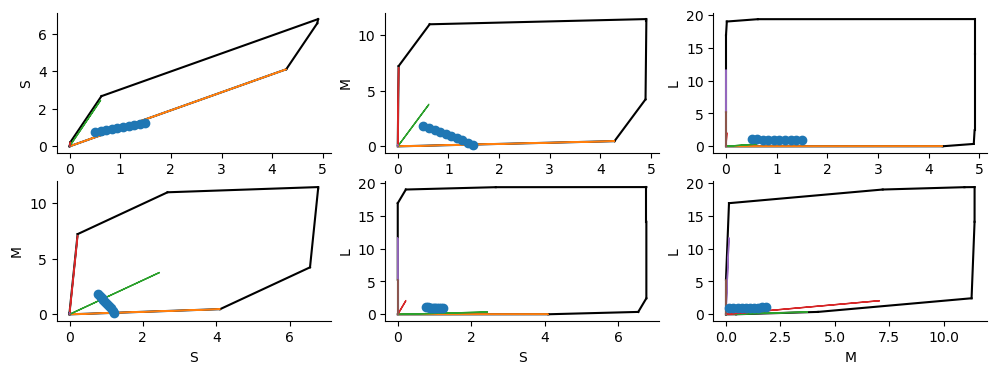

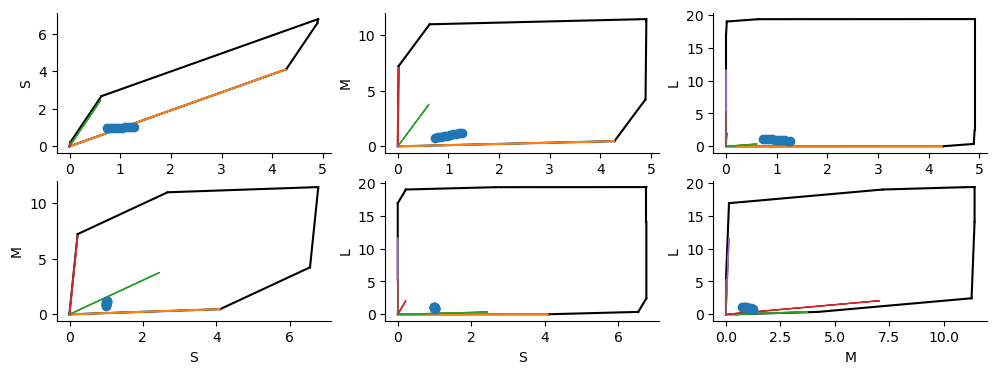

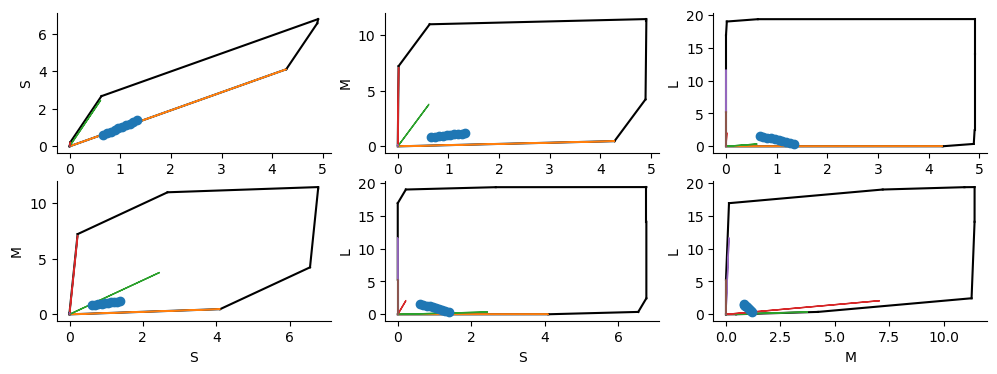

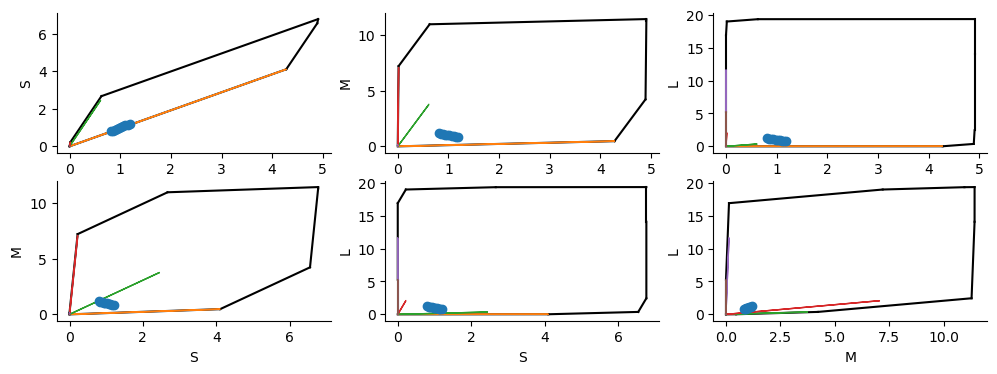

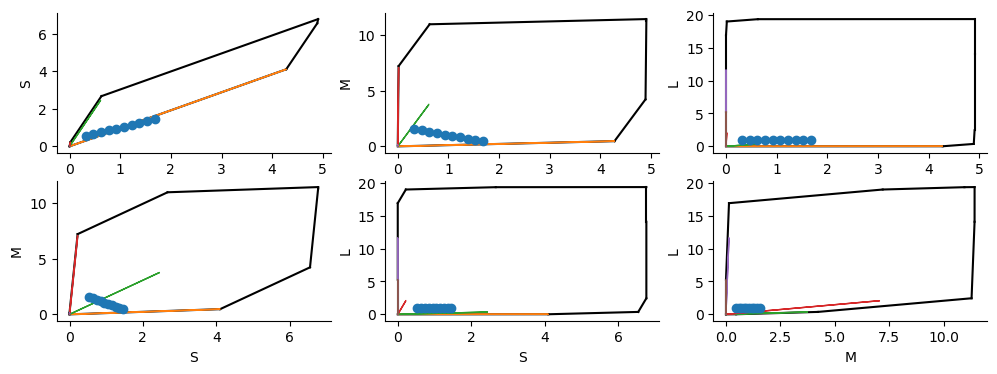

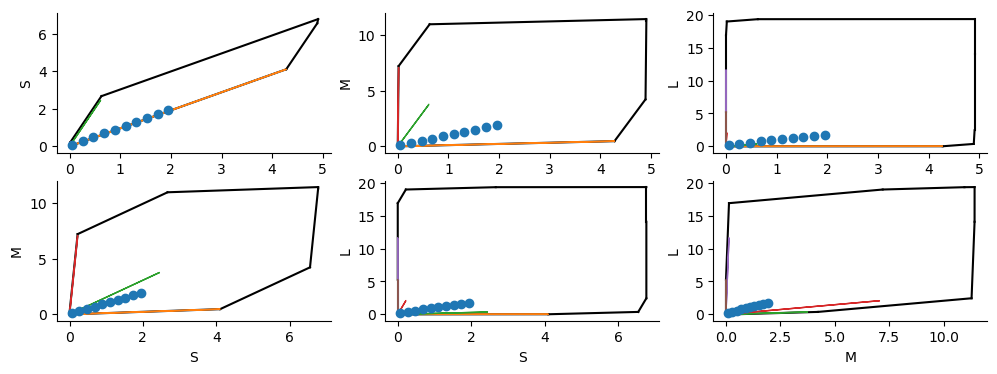

In [11]:
# test how well these dimensions span color space
for idx in range(new_dims.shape[1]):
    new_cs = new_dims[:, idx] / np.max(np.abs(new_dims[:, idx])) * np.linspace(-1, 1, 10)[:, None]
    new_abs = new_cs * source_bg + source_bg
    new_qs = est.system_relative_capture(new_abs)

    est.hull_plot(new_qs, ncols=3, fig_kws=dict(figsize=(12, 4)))
    sns.despine()
    plt.show()

/Users/gucky92/Documents/dreye/dreye/api/estimator.py:1045: UserWarning: This is an experimental method and might not work as expected. Use with caution. This method might be removed or changed in future versions.
  warnings.warn(


Fitting points...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1109.24it/s]


Fitting underdetermined system...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1231.45it/s]


Optimizing variance...


Iterations: 100%|██████████| 1000/1000 [00:00<00:00, 1021.57it/s]
/Users/gucky92/Documents/dreye/dreye/api/estimator.py:1133: UserWarning: maxout_change is an experimental feature and not thought out.
  warnings.warn("maxout_change is an experimental feature and not thought out.")


Mean capture across samples
[0.58193744 0.82827757 1.2939574  1.27794215]
Mean intensity across samples
[1.18113273e-08 1.16466633e-02 2.67560758e-02 3.09257266e-02
 2.82621672e-02 1.82224386e-02]
Background intensity
[0.01  0.01  0.018 0.025 0.02  0.02 ]
Mean contrast across samples
[-0.99999882  0.16466633  0.48644865  0.23702906  0.41310836 -0.08887807]


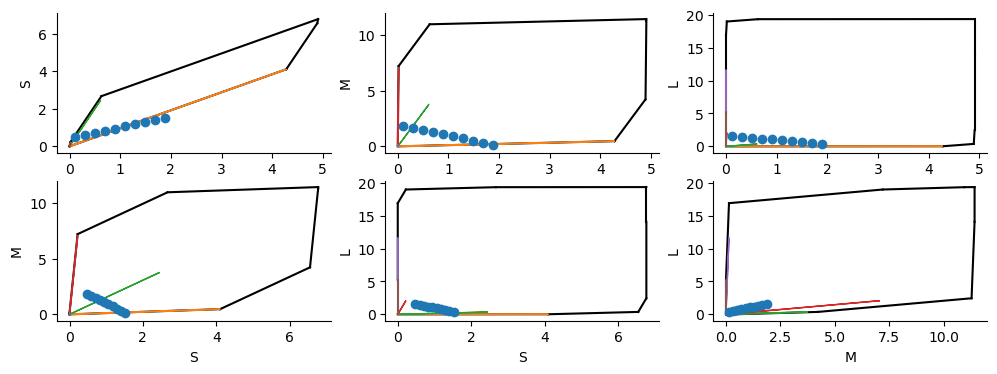

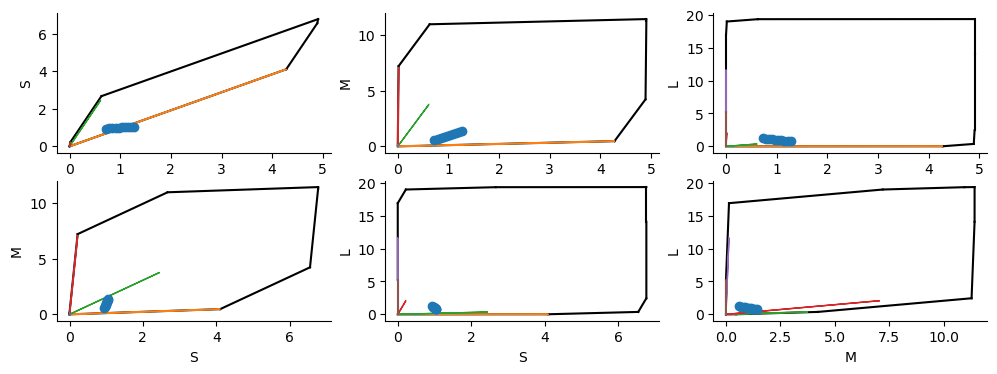

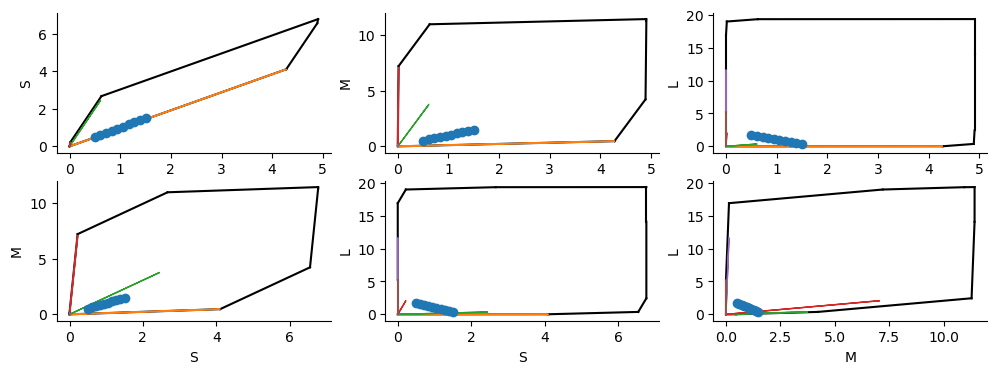

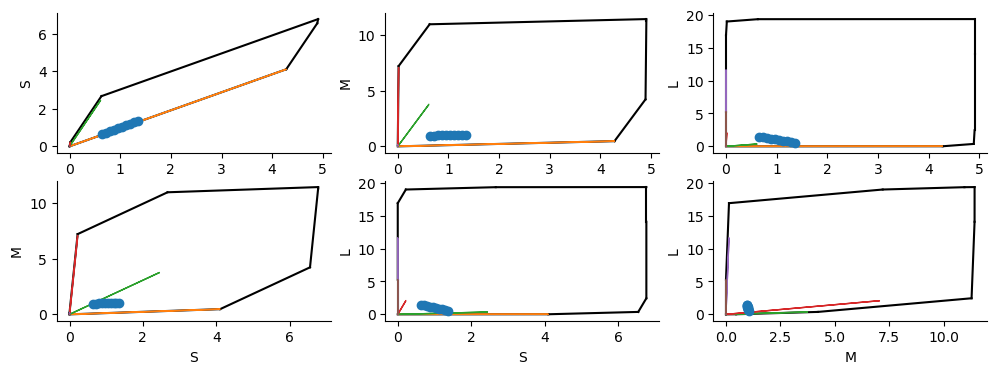

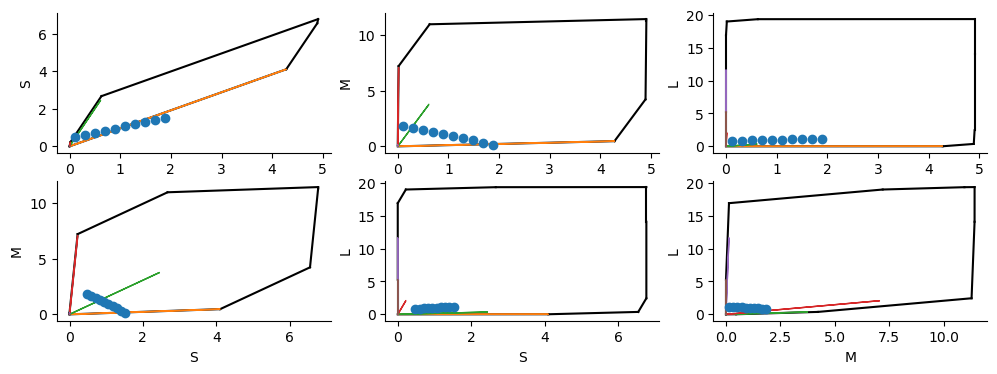

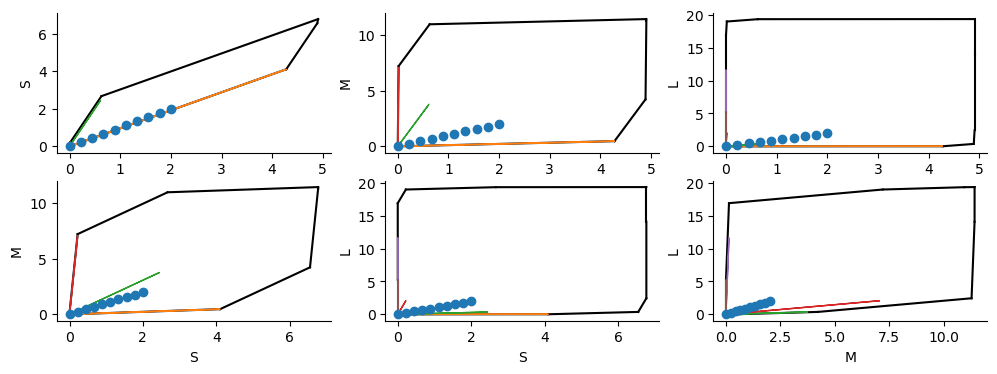

In [12]:
# test how well these dimensions span color space
custom_dims = est.find_orth_source_dimensions(verbose=1, achromatic_eps=1e-8, seed=2, maxout_change=True, correct_achromatic=False)
for idx in range(custom_dims.shape[1]):
    new_cs = custom_dims[:, idx] / np.max(np.abs(custom_dims[:, idx])) * np.linspace(-1, 1, 10)[:, None]
    new_abs = new_cs * source_bg + source_bg
    new_qs = est.system_relative_capture(new_abs)

    est.hull_plot(new_qs, ncols=3, fig_kws=dict(figsize=(12, 4)))
    sns.despine()
    plt.show()

In [13]:
np.round(new_dims, 2)

array([[ 0.86,  1.69,  0.07,  1.43,  0.6 ,  1.26],
       [ 0.83, -0.85,  1.74, -1.22,  1.08,  1.13],
       [-1.29, -1.09,  0.97,  1.58, -0.63,  1.16],
       [-1.47,  1.34,  0.16, -1.34, -0.75,  1.14],
       [-0.06, -0.75, -2.49, -0.28,  0.68,  1.17],
       [ 1.13, -0.33, -0.45, -0.16, -0.98,  0.14]])

In [14]:
np.round(custom_dims, 2)

array([[ 1. ,  1. ,  0.5,  1. ,  1. ,  1. ],
       [ 1. , -0.5,  0.5, -0.5,  1. ,  1. ],
       [-1. , -0.5,  0.5,  1. , -1. ,  1. ],
       [-1. ,  1. ,  0.5, -0.5, -1. ,  1. ],
       [-1. , -0.5, -1. , -0.5,  1. ,  1. ],
       [ 1. , -0.5, -1. , -0.5, -1. ,  1. ]])